In [45]:
# Always reload .py files
%load_ext autoreload
%autoreload 2

# Configuration
environment = 'local'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
%%capture

# Install dependencies
if environment == 'local':
    %pip install -r ../requirements.txt
else:
    %pip install ipykernel kaggle matplotlib autopep8 pillow pandas numpy scipy urllib3 scikit-image --find-links https://download.pytorch.org/whl/cu113/torch_stable.html torch==1.11.0+cu113 torchaudio==0.11.0+cu113 torchvision==0.12.0+cu113 torch_tb_profiler tensorboard

In [47]:
if environment == 'colab':
    from google.colab import files
    import pathlib
    import os

    kaggle_path = '/root/.kaggle/kaggle.json'

    if not os.path.exists(kaggle_path):
      uploaded = files.upload()

      if not 'kaggle.json' in uploaded:
          raise Exception('Kaggle.json not found')

      pathlib.Path('/root/.kaggle').mkdir(exist_ok=True)
      os.rename('./kaggle.json', kaggle_path)

      !chmod 600 /root/.kaggle/kaggle.json

In [48]:
from dataset import MonetDataset, compute_stats, download_dataset
import torchvision
import torch


# Define custom paths
data_dir = os.path.join('..', 'data')

# Download the dataset
download_dataset(data_dir)

# Define preprocessing step
process = torchvision.transforms.ConvertImageDtype(torch.float)

# Load datasets
train_dataset = MonetDataset(train=True, data_dir=data_dir, transforms=process)
test_dataset = MonetDataset(train=False, data_dir=data_dir, transforms=process)

# Compute mean and std from the datasets
train_mean, train_std = compute_stats(train_dataset)
test_mean, test_std = compute_stats(test_dataset)

# Show stats
print(f'Train Mean: {train_mean}, Train STD: {train_std}')
print(f'Test Mean: {test_mean}, Test STD: {test_std}')


dataset already exists
Train Mean: tensor([0.5214, 0.5244, 0.4768]), Train STD: tensor([0.2269, 0.2203, 0.2470])
Test Mean: tensor([0.4038, 0.4086, 0.3840]), Test STD: tensor([0.2698, 0.2495, 0.2768])


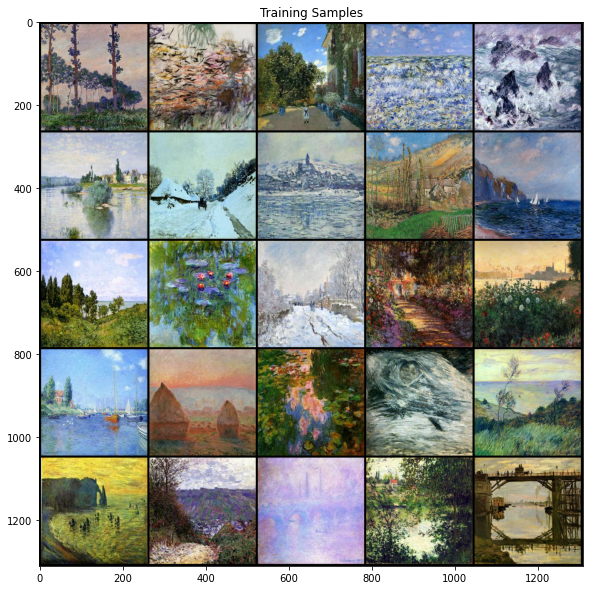

In [49]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# Create a dataloader for previewing samples
batch_size = 25
row_count = int(np.sqrt(batch_size))
preview_loader = DataLoader(train_dataset, batch_size, shuffle=True)

# Get a batch of images
preview_train_imgs = next(iter(preview_loader))

# Make a grid (image) from a couple of samples from the training dataset
preview_grid = make_grid(
    preview_train_imgs, nrow=row_count, padding=5, nromalize=True)

# Preview the samples
plt.figure(figsize=(10, 10))
plt.title('Training Samples')
plt.imshow(preview_grid.permute(1, 2, 0))
plt.show()
